In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
import torch.nn as nn
import os
from torchvision import transforms, models

import random
import cv2

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

In [4]:
import albumentations as A
from torchvision.transforms import v2

torch.cuda.empty_cache()

BS=16
LR=0.00005
epochs=20
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'


augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

class FractureData(torch.utils.data.Dataset):

    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])

        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape

        file=open(tp,'r')
        target=list(map(float,file.read().split()))

        try:
            label=[target.pop(0)]
            bbox=[]
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)

            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)

        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()

        annot={'boxes':bbox,'labels':label}

        return image, annot

    def collate_fn(self,batch):
        return tuple(zip(*batch))

In [5]:
test_dir_path='/content/drive/MyDrive/NN_Project/NEW_DATA/test'
test_img_paths = sorted(os.listdir('/content/drive/MyDrive/NN_Project/NEW_DATA/test/images'))
test_target_paths = sorted(os.listdir('/content/drive/MyDrive/NN_Project/NEW_DATA/test/labels'))

testset=FractureData(test_dir_path, test_img_paths, test_target_paths, augs)

In [6]:
#check
testset[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[ 47,  45, 169, 114],
          [ 76,  49, 202, 157]]),
  'labels': tensor([4, 4])})

In [7]:
num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

In [13]:
import torchvision
from torchvision.models.detection.ssd import SSD

def create_model(num_classes):

    model=torchvision.models.detection.ssd300_vgg16(preTrained=True)

    for param in model.parameters():
        param.requires_grad = True

    num_default_boxes = len(model.anchor_generator.aspect_ratios[0]) * len(model.anchor_generator.scales)



    model.classification_headers = nn.ModuleList([
        nn.Conv2d(256, num_classes * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(512, num_classes * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(1024, num_classes * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(512, num_classes * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(256, num_classes * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(256, num_classes * num_default_boxes, kernel_size=3, padding=1)
    ])

    model.regression_headers = nn.ModuleList([
        nn.Conv2d(256, 4 * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(512, 4 * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(1024, 4 * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(512, 4 * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(256, 4 * num_default_boxes, kernel_size=3, padding=1),
        nn.Conv2d(256, 4 * num_default_boxes, kernel_size=3, padding=1)
    ])

    # Add custom layers on top of the pre-trained model
    custom_layers = nn.Sequential(
        nn.Linear(1000, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

    # Replace the final classification layer with custom layers
    model.classifier = custom_layers

    model.to(D);
    return model

In [14]:
model = create_model(num_classes=num_classes)
checkpoint = torch.load('/content/drive/MyDrive/NN_Project/NEW_DATA/Trained_data/FullyTrainedModel (1).pt', map_location=D)
model.load_state_dict(checkpoint)
model.to(D).eval()

# define the detection threshold...
# ... any detection having score below this will be discarded
# detection_threshold = 0.8

# # to count the total number of images iterated through
# frame_count = 0

# # to keep adding the FPS for each image
# total_fps = 0

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

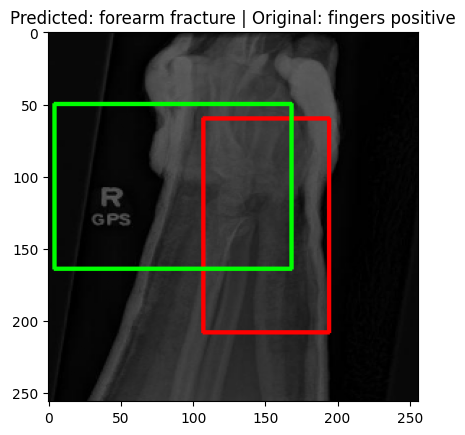

In [15]:
idx=random.randint(0,len(testset)-1)
# print(idx)
test_img,test_tar=testset[idx]
# print(test_tar) #type-dict

model.eval()

pred=model(test_img.unsqueeze(0).to(D))
# print(pred) #type-list

# pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
pred_label=pred[0]['labels'][0].item()
orig_label=test_tar['labels'][0].item()

Txmin,Tymin,Txmax,Tymax=test_tar['boxes'][0].tolist()

#predicted rectangle
image=cv2.rectangle(test_img.permute(1,2,0).numpy(),(xmin,ymin),(xmax,ymax),(255,0,0),2)

#original rectangle
image=cv2.rectangle(image,(Txmin,Tymin),(Txmax,Tymax),(0,255,0),2)

plt.imshow(image)
plt.title("Predicted: " + str(l2c[pred_label]) + " | Original: " +str(l2c[orig_label]))
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for i in range(len(testset)):
  test_img,test_tar=testset[i]
  model.eval()
  pred=model(test_img.unsqueeze(0).to(D))
  # pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
  # xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
  out=pred[0]['labels'][0].item()
  y_pred.append(out)
  org=test_tar['labels'][0].item()
  y_true.append(org)


<ipython-input-17-946e825ff1b2>:2: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],


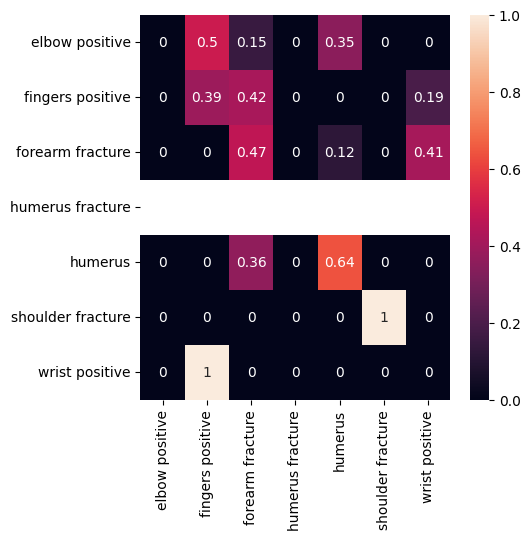

In [17]:
cf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [18]:
#check
yt = set(y_true)
print(yt)

{0, 1, 2, 4, 5, 6}


In [19]:
#check
yp = set(y_pred)
print(yp)

{1, 2, 4, 5, 6}


In [20]:
#check
print(y_pred)
print(y_true)

[4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 1, 1, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 6, 6, 6, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4,